<font size = 6> SSD Implementation </font>

<font size= 5>监督深度学习的几个核心组成与分析的切入点</font>
* <font size= 4>数据集</font>
  * <font size= 3>深度学习是数据驱动的模型，数据起到最核心的作用，在监督学习中，数据集囊括数据与标签</font>
* <font size= 4>表示</font>
  * <font size= 3>经数学证明，深度学习可以以任意精度拟合连续函数，如果视深度学习为工具、黑盒子，怎么合理地、数字化地描述工程，当前表示是否利于收敛是非常重要的问题</font>
  > Reference - Neural Network with Unbounded Activation Functions is Universal Approximator  https://arxiv.org/abs/1505.03654
* <font size= 4>模型</font>
  * <font size= 3>深度学习中模型部分主要工作是估计一个函数 $f$ 建立数据与目标间的关系</font>
  * <font size= 3>以目标检测为例，实质上希望建立关系 $label, bounding box = f(image)$ ，模型即是其中的 $f$</font>
* <font size= 4>评估</font>
  * <font size= 3>度量模型与期望间的差异，以损失函数的形式表示，常用的损失函数包含：MSELoss / Cross Entropy / L1Loss等等</font>
* <font size= 4>优化</font>
  * <font size= 3>根据评估的结果，对模型进行调整，使得模型逐步变好</font>
  * <font size= 3>深度学习常用基于梯度的优化算法，通过反向传播(BP)快速求解梯度，利用SGD、Adam等算法进行调整</font>


In [15]:
import torch
import torch.nn as nn
import torch.utils.data as data
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import math
import numpy as np
import os

<font size = 5> Part 1 数据集 </font>

<font size = 3>DIOR数据集，转化为PASCAL VOC格式</font>

Dataset Sample Number: 5862


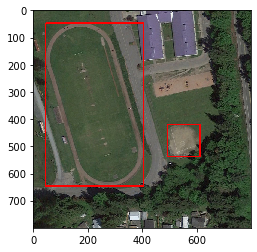

In [16]:
class ssd_voc_loader(data.Dataset):

    CLASSES = ['airplane', 'airport', 'baseballfield', 'basketballcourt', 'bridge', 'chimney', 'dam',
               'Expressway-Service-area', 'Expressway-toll-station', 'golffield', 'groundtrackfield', 
               'harbor', 'overpass','ship', 'stadium', 'storagetank', 'tenniscourt', 'trainstation', 
               'vehicle','windmill','background']
               
    def __init__(self,dataset_folder,ssd_version=300,train_loader=True):
        self.image_folder = dataset_folder + '/VOC2007/JPEGImages'
        self.anno_folder = dataset_folder + '/VOC2007/Annotations'
        self.txt_folder = dataset_folder + '/VOC2007/ImageSets/Main'
        if train_loader:
            self.txt_folder += '/train.txt'
        else:
            self.txt_folder += '/test.txt'
        # Read sets
        self.file_sets = []
        f = open(self.txt_folder,'r')
        lines = f.readlines()
        for line in lines:
            line = line.strip().split()
            self.file_sets.extend(line)
        self.file_num = len(self.file_sets)
        
    def __getitem__(self,index):
        # Parse Image
        img_path = self.image_folder + '/' + self.file_sets[index] + '.jpg'
        img = cv2.imread(img_path)
        # Parse Annotations
        anno_path = self.anno_folder + '/' + self.file_sets[index] + '.xml'
        root = ET.parse(anno_path).getroot()
        img_width = float(root.find('size').find('width').text)
        img_height = float(root.find('size').find('height').text)
        objs = root.findall('object')
        for obj in objs:
            labels = self.CLASSES.index(obj.find('name').text)
            xmin = int(obj.find('bndbox').find('xmin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,0,255),3)
        return img[:,:,::-1]
        
    def __len__(self):
        return self.file_num

dataset = ssd_voc_loader('D:/0426DIOR/DIOR/VOCdevkit')
img = dataset[522]
print('Dataset Sample Number: '+ str(len(dataset)))
plt.imshow(img)
plt.show()


<font size = 5> Part 2 表示 </font>

<font size = 3> 通过以下表示，有效地限制了四个修正参数的范围，利于神经网络收敛 </font>

$$t_x = \frac{x-x_a}{w_a}$$

$$t_y = \frac{y-y_a}{h_a}$$

$$t_w = \ln{\frac{w}{w_a}}$$

$$t_w = \ln{\frac{h}{h_a}}$$

![jupyter](./notebookpic/representation.png)

<font size = 5> Part 3 模型 </font>

<font size = 3> SSD结构 </font>

![jupyter](./notebookpic/ssd_structure.png)

<font size = 3> VGG-16 结构 </font>
![jupyter](./notebookpic/VGG16.png)

In [17]:
class conv_bn_relu(nn.Module):
    def __init__(self,inplane,plane,kernel_size=3,stride=1,padding=1,dilation=1):
        super(conv_bn_relu,self).__init__()
        self.conv = nn.Conv2d(inplane,plane,kernel_size,stride,padding,dilation)
        self.bn = nn.BatchNorm2d(plane)
        self.relu = nn.ReLU(inplace=True)
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class SSD_VGG(nn.Module):
    arch_setting = {
        11: (1, 1, 2, 2, 2),
        13: (2, 2, 2, 2, 2),
        16: (2, 2, 3, 3, 3),
        19: (2, 2, 4, 4, 4)
    }
    def __init__(self,depth=16,use_bn=True):
        super(SSD_VGG,self).__init__()
        # Only Support VGG-16
        assert(depth==16)
        self.inplane = 3
        self.plane = 64
        self.stage_settings = self.arch_setting[depth]
        self.features = []
        for i,stage_setting in enumerate(self.stage_settings):
            if(i != 4):
                layer = self._make_layers(conv_bn_relu,stage_setting,self.plane)
                self.features.extend(layer)
                self.plane = int(self.plane * 2)
            else:
                self.plane = int(self.plane / 2)
                layer =  self._make_layers(conv_bn_relu,stage_setting,self.plane,with_pool=False)
                self.features.extend(layer)
        self.features = nn.ModuleList(self.features)
        self.pool = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.fc6 = conv_bn_relu(self.inplane,1024)
        self.fc7 = conv_bn_relu(1024,1024,kernel_size=1,stride=1,padding=0,dilation=1)
            
        
    def _make_layers(self,block_type,block_nums,plane,with_pool=True):
        layers = []
        layers.append(block_type(self.inplane,plane))
        self.inplane = plane
        for i in range(1,block_nums):
            layers.append(block_type(self.inplane,plane))
        if with_pool:
            layers.append(nn.MaxPool2d(kernel_size=2,stride=2,ceil_mode=True))
        return layers
    
    def forward(self,x):
        # output conv4_3's feature map whose index is 12
        outs = []
        for i,layers in enumerate(self.features):
            x = layers(x)
            if(i == 12):
                outs.append(x)
        x = self.pool(x)
        x = self.fc6(x)
        # output fc7's feature map
        x = self.fc7(x)
        outs.append(x)
        return outs
    
model = SSD_VGG().cuda()
#print(model)
in_tsr = torch.randn(size=(1,3,300,300)).cuda()
out_tsr = model(in_tsr)
for out in out_tsr:
    print(out.size())

torch.Size([1, 512, 38, 38])
torch.Size([1, 1024, 19, 19])


In [18]:
class SSD300(nn.Module):
    def __init__(self,box_settings=[4,6,6,6,4,4],
                      out_channels = [512,1024,512,256,256,256],
                      class_num=20):
        super(SSD300,self).__init__()
        self.class_num = class_num
        self.base_net = SSD_VGG()
        self.extra_layer1 = nn.Sequential(
            nn.Conv2d(1024,256,kernel_size=1,stride=1,padding=0,dilation=1),
            nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1,dilation=1),
        )
        self.extra_layer2 = nn.Sequential(
            nn.Conv2d(512,128,kernel_size=1,stride=1,padding=0,dilation=1),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1,dilation=1),
        )
        self.extra_layer3 = nn.Sequential(
            nn.Conv2d(256,128,kernel_size=1,stride=1,padding=0,dilation=1),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1,dilation=1),
        )
        self.extra_layer4 = nn.Sequential(
            nn.Conv2d(256,128,kernel_size=1,stride=1,padding=0,dilation=1),
            nn.Conv2d(128,256,kernel_size=3,stride=1),
        )
        self.cls_convs = []
        self.reg_convs = []
        for i,box_setting in enumerate(box_settings):
            self.cls_convs.append(nn.Conv2d(out_channels[i],box_setting*(self.class_num+1),kernel_size=3,padding=1))
            self.reg_convs.append(nn.Conv2d(out_channels[i],box_setting*4,kernel_size=3,padding=1))
        self.cls_convs = nn.ModuleList(self.cls_convs) 
        self.reg_convs = nn.ModuleList(self.reg_convs)
        
    def forward(self,x):
        # Get Feature Maps Here
        feats = []
        x = self.base_net(x)
        feats.extend(x)
        x = x[1]
        x = self.extra_layer1(x)
        feats.append(x)
        x = self.extra_layer2(x)
        feats.append(x)
        x = self.extra_layer3(x)
        feats.append(x)
        x = self.extra_layer4(x)
        feats.append(x)
        # Pass All The Reg & Cls Module
        cls_pred = []
        reg_pred = []
        for i,cls_conv in enumerate(self.cls_convs):
            cls_pred.append(cls_conv(feats[i]).permute(0,2,3,1).contiguous())
            reg_pred.append(self.reg_convs[i](feats[i]).permute(0,2,3,1).contiguous())
        cls_pred = torch.cat([c.view(c.size(0),-1,self.class_num+1) for c in cls_pred],1)
        reg_pred = torch.cat([r.view(r.size(0),-1,4) for r in reg_pred],1)
        return cls_pred,reg_pred
    
model = SSD300().cuda()
#print(model)
test_tsr = torch.randn(size=(1,3,300,300)).cuda()
cls,reg = model(test_tsr)
print(cls.size(),reg.size())

torch.Size([1, 8732, 21]) torch.Size([1, 8732, 4])


<font size = 3> Prior Box Generating </font>

<font size = 3> Anchor锚框是作为强先验的存在，对于SSD的多尺度特征图结构，很自然地会有一个想法，用尺寸小的特征图探测大目标，用尺寸大的特征图探测小目标，因此在不同的特征图上，生成不同尺寸的先验锚框 </font>
$$s_k=s_{min}+\frac{s_{max}-s_{min}}{5}(k-1),k\in[1,6]$$
以SSD-300为例，$s_{min}\times300$代表conv4_3输出特征图生成anchor的基准尺寸，$s_{max}\times300$代表最后一个特征图生成anchor的基准尺寸，中间层anchor的基准尺寸均匀排布，以$s_{min}=0.2,s_{max}=0.8$为例，各层对应的基准尺寸如下:

In [19]:
s_min = 0.2
s_max = 0.8
default_size  = []
for i in range(1,7):
    s_k = s_min+(s_max-s_min)*(i-1)/(6-1)
    version_specific_size = s_k * 300
    default_size.append(version_specific_size)
for i,size in enumerate(default_size):
    print('feature_map index: %d default box size: %.f'%(i+1,size))

feature_map index: 1 default box size: 60
feature_map index: 2 default box size: 96
feature_map index: 3 default box size: 132
feature_map index: 4 default box size: 168
feature_map index: 5 default box size: 204
feature_map index: 6 default box size: 240


<font size = 3>对于某一层的特征图，其生成的锚框包括$\{s_{k},\sqrt{s_{k}\times s_{k+1}},s_{k,ratio1},s_{k.ratio2},...,s_{k_ratio}\}$</font>

<font size = 3>长宽比变换的公式为$w=\frac{s_k}{\sqrt{ratio}}$ $h=s_k \times \sqrt{ratio}$</font>

<font size = 3> 将锚框平铺到原图上，与标签计算交并比 $IoU = \frac{A\cap B}{A\cup B}$ ， $IoU>0.5$ 为正样本,反之为负样本，即可以计算target </font>

<font size = 3>下有生成效果</font>



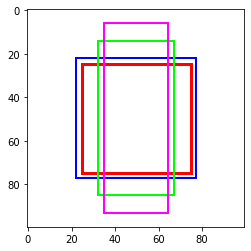

In [20]:
s_k = 50
s_kp1 = 60
ratios = [2,3]
box = []
box1 = [50,50,s_k,s_k]
box.append(box1)
box2 = [50,50,math.sqrt(s_kp1*s_k),math.sqrt(s_kp1*s_k)]
box.append(box2)
for ratio in ratios:
    w = s_k / math.sqrt(ratio)
    h = s_k * math.sqrt(ratio)
    box_temp = [50,50,w,h]
    box.append(box_temp)

img = np.zeros((100,100,3),dtype=np.uint8)
img.fill(255)

color = [(0,0,255),(255,0,0),(0,255,0),(255,0,255)]
for i,boxi in enumerate(box):
    tl_x = int(boxi[0]-boxi[2]/2.)
    tl_y = int(boxi[1]-boxi[3]/2.)
    br_x = int(boxi[0]+boxi[2]/2.)
    br_y = int(boxi[1]+boxi[3]/2.)
    cv2.rectangle(img,(tl_x,tl_y),(br_x,br_y),color[i],1)
img2 = img[:,:,::-1]
plt.imshow(img2)
plt.show()

<font size = 5> Part 4 评估 </font>

<font size = 3> 分类误差采用交叉熵Cross Entropy，定位误差使用Smooth L1 Loss避免误差过大导致不收敛问题 </font>

<font size = 5> Part 5 优化 </font>

<font size = 3 > 非常灵活，使用SGD/Adam等等均可，本次复现使用的是SGD</font>

<font size = 5> Part 6 我的复现 </font>
> <font size = 3> Github links of this code -  https://github.com/YummyWaffle/my_SSD </font>

In [ ]:
%run TrainSSD.py